# LA PNEUMONIE

<img src =./image/pneumonie_schema.jpeg>

La pneumonie est une inflammation des poumons habituellement causée par une infection virale ou bactérienne. Lorsque les poumons sont infectés, les micro-organismes responsables se multiplient dans les alvéoles, les petits sacs microscopiques où le sang se charge en oxygène et élimine le dioxyde de carbone. Celles-ci se remplissent de liquide inflammatoire ou de pus et les échanges gazeux ont du mal à se faire. Les pneumonies sont potentiellement graves, notamment lorsqu’elles touchent des personnes souffrant de maladies chroniques.

Dans la plupart des cas, un seul lobe pulmonaire est atteint (les poumons se composent de cinq lobes) ce qui permet à la personne malade de ne pas mourir asphyxiée.

# 1. Chargement et exploration des données

1.1 Import des bibliothèques

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import cv2
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from pathlib import Path
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import seaborn as sns
import mlflow
import mlflow.tensorflow
from keras.layers import Activation, Dense
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization, GlobalAveragePooling2D
import random


commande dans un powershell pour lancer un serveur local mlflow pour voir les différents test de model et leurs performence     
  "mlflow server --host 127.0.0.1 --port 8080"

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080/")

1.2 Structure du dataset

On remarque qu'il a différence importante entre les résultat positif(PNEUMONIA) et négatif(NORMAL) il faudra prendre en compte dans l'entrainement du model faire un equilibrage avec les poids

In [ ]:
def count_picture_pos(path :str)->int:
    val_neg=0
    val_neg = len(os.listdir(f"{path}/NORMAL"))
    return val_neg

def count_picture_neg(path :str)->int:
    val_pos=0
    val_pos = len(os.listdir(f"{path}/PNEUMONIA"))
    return val_pos
    
test_path="data/chest_xray/test"
train_path="data/chest_xray/train"
val_path="data/chest_xray/val"
path_path=""
doc = ["test","train","val"]
total=0
for dir in doc:
    path=""
    if (dir=="test"):
        path=test_path
    elif(dir=="train"):
        path=train_path
    else:
        path=val_path
        
        
    print(f"Nombre d'image dans le {dir} : {count_picture_pos(path) + count_picture_neg(path) }")
    print(f"Nombre d'image dans le NORMAL : {count_picture_pos(path)}")
    print(f"Nombre d'image dans le PNEUMONIA : {count_picture_neg(path)}")
    total +=count_picture_pos(path) + count_picture_neg(path)
print(f"Nombre d'image total d'image est de : {total}")

nombre d'image dans le test : 624
nombre d'image dans le NORMAL : 234
nombre d'image dans le PNEUMONIA : 390
nombre d'image dans le train : 5216
nombre d'image dans le NORMAL : 1341
nombre d'image dans le PNEUMONIA : 3875
nombre d'image dans le val : 16
nombre d'image dans le NORMAL : 8
nombre d'image dans le PNEUMONIA : 8
nombre d'image total d'image est de : 5856


1.3 Affichage d’exemple d’image

array([[[  1,   1,   1],
        [220, 220, 220],
        [220, 220, 220],
        ...,
        [ 18,  18,  18],
        [ 13,  13,  13],
        [ 12,  12,  12]],

       [[  0,   0,   0],
        [196, 196, 196],
        [197, 197, 197],
        ...,
        [ 17,  17,  17],
        [ 15,  15,  15],
        [ 14,  14,  14]],

       [[  1,   1,   1],
        [176, 176, 176],
        [181, 181, 181],
        ...,
        [ 15,  15,  15],
        [ 14,  14,  14],
        [ 13,  13,  13]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

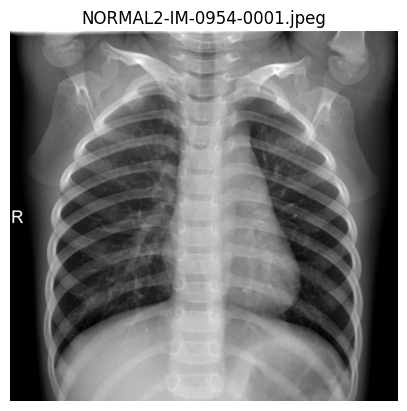

Shape (dimension)  :`(1499, 1570, 3)
Type des valeurs   : uint8


array([[[90, 90, 90],
        [89, 89, 89],
        [88, 88, 88],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[90, 90, 90],
        [89, 89, 89],
        [89, 89, 89],
        ...,
        [ 3,  3,  3],
        [ 1,  1,  1],
        [ 0,  0,  0]],

       [[90, 90, 90],
        [90, 90, 90],
        [90, 90, 90],
        ...,
        [ 7,  7,  7],
        [ 5,  5,  5],
        [ 3,  3,  3]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]]], dtype=uint8)

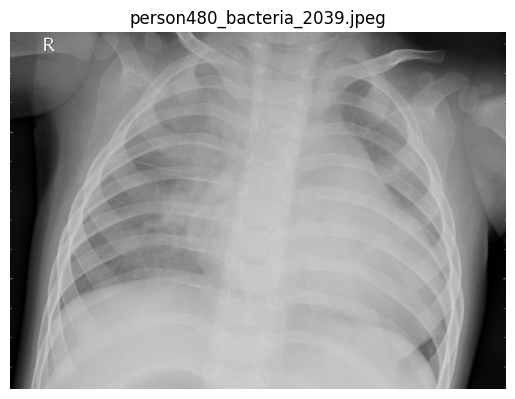

Shape (dimension)  :`(760, 1056, 3)
Type des valeurs   : uint8


In [ ]:
#prend une image aléatoire en train normal
path="data/chest_xray/train/NORMAL"
filename=random.choice(os.listdir('data/chest_xray/train/NORMAL/'))
img = cv2.imread(f"{path}/{filename}")
display(img)
plt.imshow(img)
plt.title(f"{filename}")
plt.axis("off")
plt.show()

print(f"Shape (dimension)  :`{img.shape}")
print(f"Type des valeurs   : {img.dtype}")
#prend une image aléatoire en train pneumonia
path="data/chest_xray/train/PNEUMONIA"
filename=random.choice(os.listdir('data/chest_xray/train/PNEUMONIA/'))
img2 = cv2.imread(f"{path}/{filename}")
display(img2)
plt.imshow(img2)
plt.title(f"{filename}")
plt.axis("off")
plt.show()

print(f"Shape (dimension)  :`{img2.shape}")
print(f"Type des valeurs   : {img2.dtype}")


# 2. Préprocessing

J'ai choisi de travailer avec le model DenseNet121 car il a un taux de précision est il adapté a cette étude médical.  
-  Pour le traitement d'image on va utiliser ImageDataGenerator car il est bien adapter pour DenseNet 121.
-  On zoom et change la positionnement de l'image vertical et horizontalement de manére aléatoire pour mieux entranier le model.

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    vertical_flip=False
)

val_test_datagen = ImageDataGenerator(rescale=1./255.0)

# 3. Préparation des données

On choisi de garder les couleurs car il s'adapte bien avec le modéle DenseNet121 mais aussi pour raison que de luminosité pour que le model détecte mieux les résultat positif.
On change le Batch a 16 au lieux de 32 pour le Val car il a moin d'échantillon de donné que le Train que test et train

In [ ]:
train_generator  = datagen.flow_from_directory(
    'data/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb',
)

test_generator = val_test_datagen.flow_from_directory(
    'data/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb',   
)

val_generator = val_test_datagen.flow_from_directory(
    'data/chest_xray/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb',
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Il est nécessaire de fair eun équilibrage au niveau des poids car au niveau des train les positif (Pneumonie) et négatif (Poid) on remarque une différence d'image conséquente.
- Nombre d'image dans le test : 624
- Nombre d'image dans le NORMAL : 234
- Nombre d'image dans le PNEUMONIA : 390

In [8]:
# Récupère les labels du train
labels = train_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict= dict(enumerate(class_weights))
print("Class weights:", class_weights)
display(labels)

Class weights: [1.9448173  0.67303226]


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Callback qui permet d'éviter le overfitting

In [9]:
# === Callbacks ===
checkpoint_path = "best_model.h5"
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# 4. Modéle

Entrainement en freeze  
  pré-entrainement du model pour que l'entrainement soit plus précis et plus rapide

In [10]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False #freeze

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    Dropout(0.35),
    layers.Dense(units=16, activation="relu"),
    layers.BatchNormalization(),
    Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),                            # adam =Méthode d’optimisation (descente de gradient) rmsprop=la propagation quadratique moyenne
    loss='binary_crossentropy',      # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
    metrics=['accuracy'],                         # On surveille l’exactitude pendant l'entraînement
)

Nombre de paramétre du model

In [11]:
# Résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,071,041 (26.97 MB)

 Trainable params: 33,441 (130.63 KB)

 Non-trainable params: 7,037,600 (26.85 MB)

In [12]:
mlflow.set_experiment("Pneumonia_TransferLearning_CNN")
mlflow.tensorflow.autolog()

In [13]:
history=model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=4,
            class_weight=class_weights_dict,
            callbacks=callbacks
        )


2025/05/28 09:20:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '48dd4416a6c94f349a975c2f0a28296e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/28 09:20:19 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 09:20:19 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\simplon dev\python\W6\Transfer_Learning_Pneumonia\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7745 - loss: 0.4334

163/163 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.7749 - loss: 0.4328 - val_accuracy: 0.8750 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9173 - loss: 0.2258

163/163 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.9173 - loss: 0.2257 - val_accuracy: 0.8750 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9224 - loss: 0.2068

163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9225 - loss: 0.2067 - val_accuracy: 0.9375 - val_loss: 0.1829 - learning_rate: 0.0010
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9360 - loss: 0.1733 - val_accuracy: 0.8125 - val_loss: 0.5419 - learning_rate: 0.0010


2025/05/28 09:42:32 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 09:42:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 09:42:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run mercurial-trout-785 at: http://127.0.0.1:8080/#/experiments/845456507028104026/runs/48dd4416a6c94f349a975c2f0a28296e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/845456507028104026


Entrainement en unfreeze

In [14]:
base_model.trainable = True #unfreeze
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),                            # adam =Méthode d’optimisation (descente de gradient) rmsprop=la propagation quadratique moyenne
    loss='binary_crossentropy',      # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
    metrics=['accuracy'],                         # On surveille l’exactitude pendant l'entraînement
)
mlflow.end_run()

with mlflow.start_run(run_name='densenet121l_V3'):
    history=model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=8,
            class_weight=class_weights_dict,
            callbacks=callbacks
        )
    


2025/05/28 09:42:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 09:42:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8571 - loss: 0.3977

163/163 ━━━━━━━━━━━━━━━━━━━━ 1278s 8s/step - accuracy: 0.8574 - loss: 0.3969 - val_accuracy: 0.6875 - val_loss: 0.7524 - learning_rate: 1.0000e-05
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9217 - loss: 0.1827

163/163 ━━━━━━━━━━━━━━━━━━━━ 1290s 8s/step - accuracy: 0.9218 - loss: 0.1827 - val_accuracy: 0.8750 - val_loss: 0.3358 - learning_rate: 1.0000e-05
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 1228s 8s/step - accuracy: 0.9401 - loss: 0.1689 - val_accuracy: 0.8750 - val_loss: 0.3445 - learning_rate: 1.0000e-05
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 1242s 8s/step - accuracy: 0.9407 - loss: 0.1495 - val_accuracy: 0.8750 - val_loss: 0.3374 - learning_rate: 1.0000e-05
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9552 - loss: 0.1275

163/163 ━━━━━━━━━━━━━━━━━━━━ 1288s 8s/step - accuracy: 0.9552 - loss: 0.1275 - val_accuracy: 0.8750 - val_loss: 0.2896 - learning_rate: 5.0000e-06
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9591 - loss: 0.1194

163/163 ━━━━━━━━━━━━━━━━━━━━ 1377s 8s/step - accuracy: 0.9591 - loss: 0.1194 - val_accuracy: 0.8750 - val_loss: 0.2762 - learning_rate: 5.0000e-06
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9566 - loss: 0.1168

163/163 ━━━━━━━━━━━━━━━━━━━━ 1292s 8s/step - accuracy: 0.9566 - loss: 0.1168 - val_accuracy: 0.8750 - val_loss: 0.2630 - learning_rate: 5.0000e-06
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 1240s 8s/step - accuracy: 0.9613 - loss: 0.1223 - val_accuracy: 0.8750 - val_loss: 0.2805 - learning_rate: 5.0000e-06


2025/05/28 12:33:27 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 12:33:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 12:33:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run densenet121l_V3 at: http://127.0.0.1:8080/#/experiments/845456507028104026/runs/8ef8b1aa3b7a4df984e6953266a34c7c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/845456507028104026


# 5. Evaluation

Accuracy test(97%)

  Accuracy val(87.5%)

  une différence -9.5% Un écart qui semble correct.

In [15]:
loss, acc = model.evaluate(val_generator)
print(f"Accuracy sur le test : {acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.2630
Accuracy sur le test : 87.50%


Courbe évolution de la perte
  On remarque que plus les epoches augmente plus la perte est faible.
  Les 2 courbes semble avoir une évolution similaire avec le nombre d'epoches.


Courbe évolution de la précision
  Accuracy train semble avoir besoin plus d'epoches pour se stabilisé.
  Pour la courbe dés la premier epoche l'accuracy semble fixe. 
  Aucune évolution de précision.


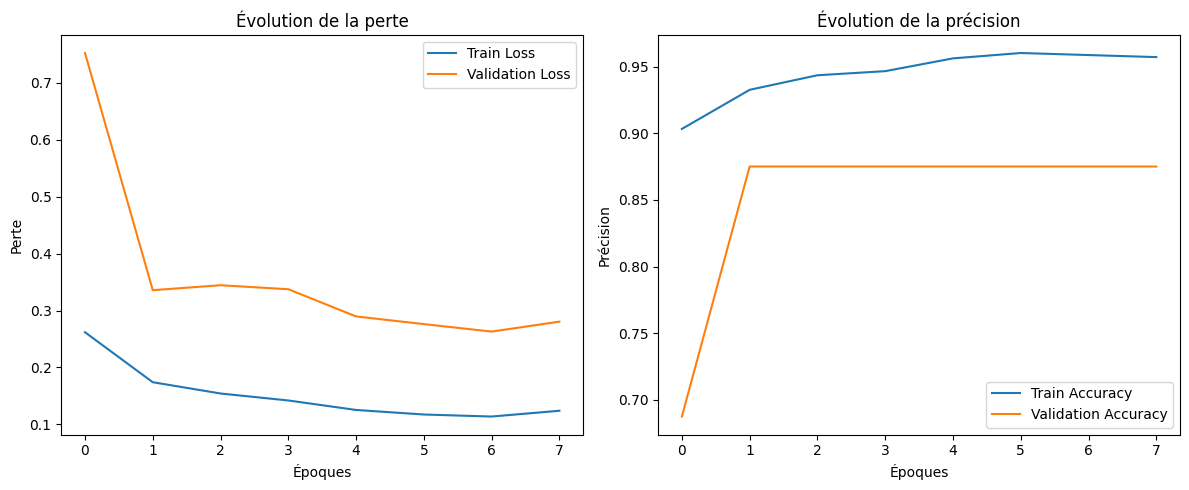

In [16]:
# --- Courbe de la perte ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Évolution de la perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# --- Courbe de la précision ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Évolution de la précision")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()

plt.tight_layout()
plt.show()

# Matrice de confusion prediction sur les tests

On remarque qu'on beaucoup de faut positif, faux négatif c'est a dire que l'entrainement du model n'est pas représentatif de l'entrainement.

  Le model est entrainer pour detecter les cas de penumonie mais a beaucoup de mal pour les cas NORMAL.
  
   Le modéle n'est pas généraliste.
  
  Cela peut indiquer un déséquilibre dans les données ou une mauvaise généralisation du modèle.

  On peux remarquer le même constat avec le Rapport de classification.

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


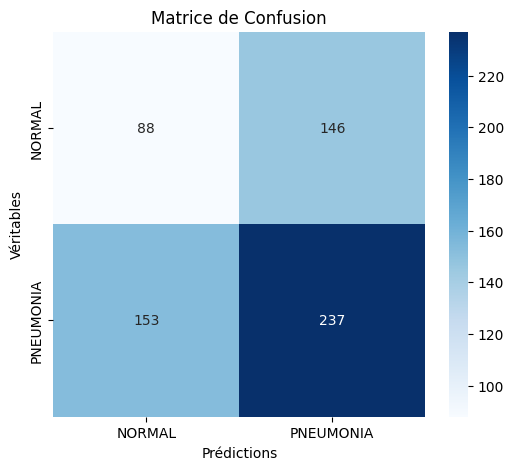


Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       0.37      0.38      0.37       234
   PNEUMONIA       0.62      0.61      0.61       390

    accuracy                           0.52       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.52      0.52       624



In [18]:
# Étape 1 : Prédiction
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = (Y_pred > 0.5).astype("int32").reshape(-1)  # Pour classification binaire

# Étape 2 : Étiquettes vraies
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Étape 3 : Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Étape 4 : Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.savefig("./image/confusion_matrix.png")
plt.show()

print("\nRapport de classification :")
print(classification_report(y_true, y_pred, target_names=class_names))

# Roc / precision prediction sur les tests

Courbe Roc

  - On remarque que la courbe ROC est trés est proche de la ligne pointilé linéaire cela signifie que
  - le modéle de prédiction est instable.

Courbe de Précision-Rappel.

  On remarque qu'il a un pique de d'instabilité qui passe de 1 à 0 au début et il se stabilise a 0.6~0.7
  - AP qui reste constant. On remarque que le AP se situe entre 0.6 et 0.7 on a un cas de underfitting.
  - Je suppose que le probléme se situe au niveau du traitement d'image


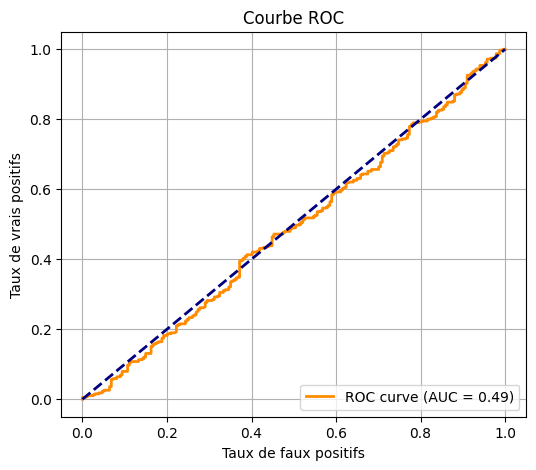

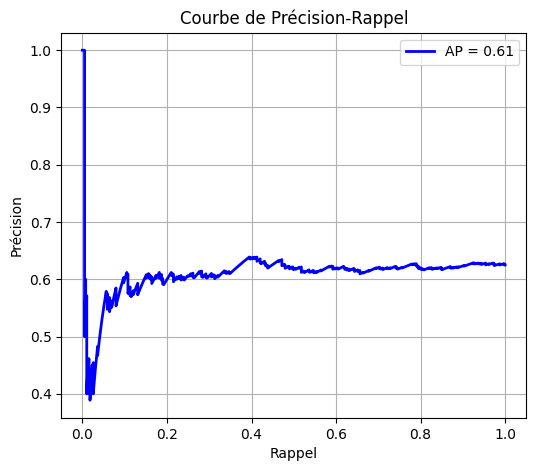

In [20]:
# === ROC ===
fpr, tpr, _ = roc_curve(y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
roc_path = "./image/roc_curve.png"
plt.savefig(roc_path)
plt.show()
plt.close()

# === Precision-Recall ===
precision, recall, _ = precision_recall_curve(y_true, Y_pred)
avg_precision = average_precision_score(y_true, Y_pred)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f"AP = {avg_precision:.2f}")
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision-Rappel')
plt.legend(loc="upper right")
plt.grid(True)
pr_path = "./image/precision_recall_curve.png"
plt.savefig(pr_path)
plt.show()
plt.close()

mlflow.log_artifact("./image/roc_curve.png")
mlflow.log_artifact("./image/precision_recall_curve.png")
mlflow.log_artifact("./image/confusion_matrix.png")

model.save("model_pneumonia.h5")
mlflow.log_artifact("model_pneumonia.h5")


In [21]:
mlflow.end_run()

🏃 View run spiffy-tern-706 at: http://127.0.0.1:8080/#/experiments/845456507028104026/runs/3159107cb80243e18d5ee50ce46c10c4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/845456507028104026


Image aleatoire avec prédiction l'image de gauche est image NORMAL et a droite l'image PNEUMONIE dans le repertoire test du dataset chest xray.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


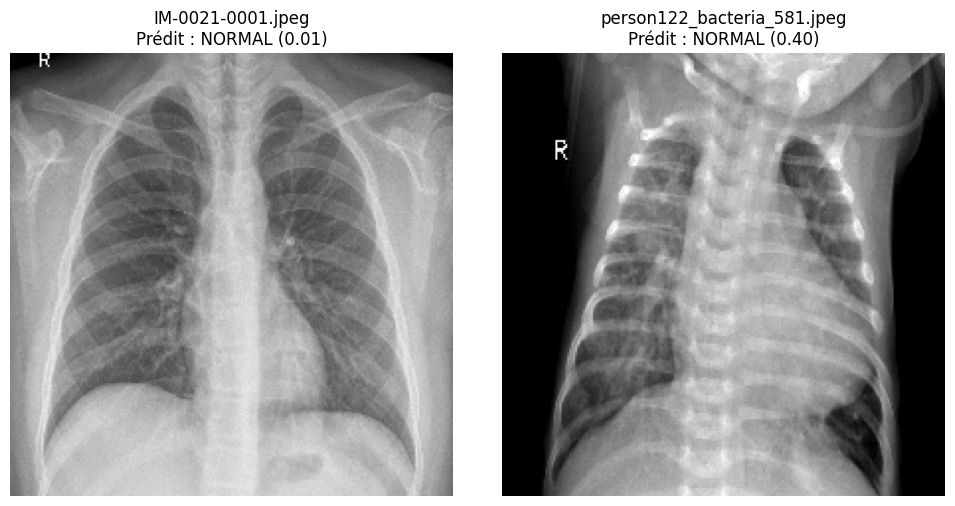

In [22]:
#chemins label image
normal_path = 'data/chest_xray/test/NORMAL'
pneumonia_path = 'data/chest_xray/test/PNEUMONIA'

# Sélection aléatoire
normal_img_name = random.choice(os.listdir(normal_path))
pneumonia_img_name = random.choice(os.listdir(pneumonia_path))

# Chargement des images
def load_and_prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Batch size 1
    return img, img_array

# Image 1 : NORMAL
normal_img_fullpath = os.path.join(normal_path, normal_img_name)
normal_img, normal_array = load_and_prepare_image(normal_img_fullpath)

# Image 2 : PNEUMONIA
pneumonia_img_fullpath = os.path.join(pneumonia_path, pneumonia_img_name)
pneumonia_img, pneumonia_array = load_and_prepare_image(pneumonia_img_fullpath)

# Prédictions
pred_normal = model.predict(normal_array)[0][0]
pred_pneumonia = model.predict(pneumonia_array)[0][0]

# Affichage
plt.figure(figsize=(10, 5))

# Image NORMAL
plt.subplot(1, 2, 1)
plt.imshow(normal_img)
plt.title(f"{normal_img_name}\nPrédit : {'NORMAL' if pred_normal < 0.5 else 'PNEUMONIA'} ({pred_normal:.2f})")
plt.axis('off')

# Image PNEUMONIA
plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img)
plt.title(f"{pneumonia_img_name}\nPrédit : {'NORMAL' if pred_pneumonia < 0.5 else 'PNEUMONIA'} ({pred_pneumonia:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()

# TARGET

La cellule suivante est le code qui permet de lancer une préduction d'une seul image dans le dossier targetimg.

-  Valeur inférieur a 0.5 = NORMAL (négatif)
-  Valeur supérieur a 0.5 = PNEUMONIA (positif)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


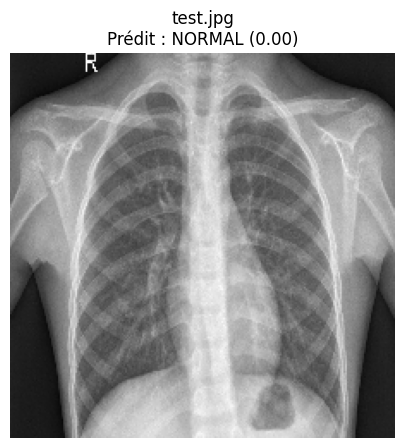

In [23]:
#chemin image
target_path = 'targetimg'

# Récupérer le nom de l’unique image dans le dossier
target_img_name = os.listdir(target_path)[0]  #il n’y a qu’une image
target_img_fullpath = os.path.join(target_path, target_img_name)

# Fonction de chargement et préparation
def load_and_prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Batch size 1
    return img, img_array

# Charger et préparer l’image
img_display, img_array = load_and_prepare_image(target_img_fullpath)

# Prédiction
prediction = model.predict(img_array)[0][0]

# Affichage
plt.figure(figsize=(5, 5))
plt.imshow(img_display)
plt.title(f"{target_img_name}\nPrédit : {'NORMAL' if prediction < 0.5 else 'PNEUMONIA'} ({prediction:.2f})")
plt.axis('off')
plt.show()

# CONCLUSION

<img src =./image/models_graph.png>

## 📈 Liste des différents model utilisé

  - DenseNet121
  - MobileNetV3Small
  - MobileNetV3Large

  Avec les même paramêtre pour chaque modéle
  
## ⏱️ Temps d'entrainement pour 8 epoches (plus rapide au moin rapide)
  - MobileNetV3Small (20 min)
  - MobileNetV3Large (40 min)
  - DenseNet121      (1h20 min)

## 🔎 Analyse et Comparaison

  **La raison pour laquel j'ai choisi le model DenseNet121 sont les suivantes**
- **Loss/val_loss trop élevés** (souvent > 0.5) avec les modèles MobileNet, ce qui indique un risque d’overfitting.  
- **Accuracy très instable** avec MobileNetV3Small.  
- **Matrice de confusion** bien plus alignée avec l’accuracy sur les données de test avec DenseNet121.  
- **Rappel (Recall)** nettement meilleur avec DenseNet121, avec un écart de +5 à +8 % par rapport aux autres modèles.  

Quand les courbes de perte (loss/val_loss) restent trop hautes, le modèle est souvent en surapprentissage (overfitting) : il s’adapte trop bien aux données d'entraînement et n’arrive plus à généraliser.  
Sur les graphiques, on voit que **MobileNetV3Small et Large ont ce problème clairement.**

## ✅ Conclusion

Parmi les trois modèles testés, **DenseNet121** s’est démarqué malgré un temps d’entraînement plus long. Il offre :

- Une **meilleure capacité supérieur de généralisation**,  
- Une **métrique de rappel supérieure**,  
- Une **précision plus cohérente**,  
- Et une **matrice de confusion plus fidèle à la réalité**.

Même si les modèles MobileNet sont rapides et légers, leur performance s’est révélée trop instable ou imprécise dans ce cas. DenseNet121,
  bien qu’exigeant en ressources, est le **meilleur compromis** ici entre précision, stabilité et pertinence pour la détection de pneumonie sur rayons X.